In [12]:
from figures_handler import method_colors as method_colors
from figures_handler import method_names as method_names
from figures_handler import colors as colors
import matplotlib.patches as mpatches
from pandas.plotting import table
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import figures_handler as fh
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [13]:
# get the project root
dir_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(dir_path, os.pardir))

experiment_directory = os.path.join(project_root, 'experiments_settings', "experiments_fragmentation_depth.csv")
data_folder, results_directory, matches_directory, libraries, library_names = fh.get_basic_data(project_root)

display(libraries[['Library', 'short_name']])


,Library,short_name
0,GNPS-MSMLS,lib1
1,GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE,lib2
2,GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE,lib3
3,BERKELEY-LAB,lib4


In [14]:
df = pd.read_csv(experiment_directory)

In [15]:
map_to_data = {}
map_to_ambiguity = {}
for library in library_names:
    library_rows = df[df['library'] == library]
    data = {}
    for index, row in library_rows.iterrows():
        try:
            data[row['id']] = pd.read_csv(os.path.join(results_directory, row['id'],  "combined.csv"))
        except:
            pass
    for index, row in library_rows.iterrows():
        try:
            depth = row['fragmentation_depth']
            fragment_filter = row['fragment_filter']
            if fragment_filter not in map_to_data:
                map_to_data[fragment_filter] = {}
                map_to_ambiguity[fragment_filter] = {}
            
            temp_data = data[row['id']]
            temp_data = temp_data[temp_data['shifted_annotated_ambiguity'] > 0]
            # temp_data = temp_data[temp_data['shifted'] > 0]

            if depth not in map_to_data[fragment_filter]:
                map_to_data[fragment_filter][depth] = []
                map_to_ambiguity[fragment_filter][depth] = []
            
            map_to_data[fragment_filter][depth].extend(temp_data['average_dist_normalized'].values)
            x = temp_data['shifted_annotated_ambiguity'].values
            # remove outliers
            top_75 = np.percentile(x, 75)
            top_25 = np.percentile(x, 25)
            iqr = top_75 - top_25
            map_to_ambiguity[fragment_filter][depth].extend(x[x < top_75 + 1.5 * iqr])
        except:
            pass
    

In [16]:
len(map_to_data['none'][2])

8033

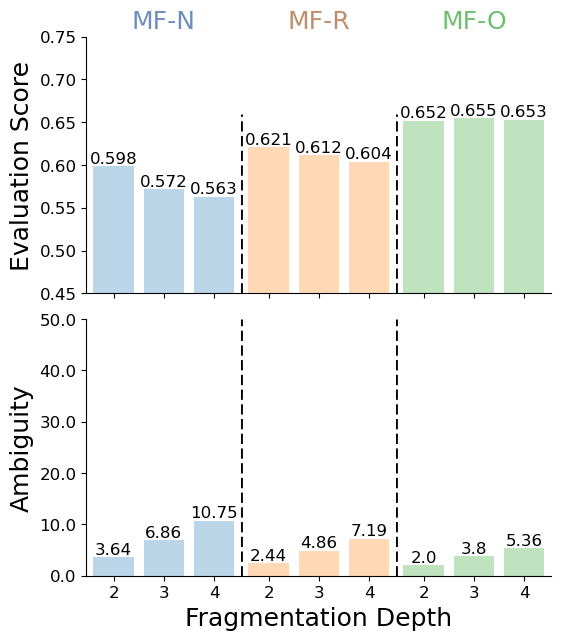

In [17]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
font_labels = {'family' : 'sans-serif',
        # 'weight' : 'bold',
        'size'   : 18}

colors = ['#bbd5e8', '#ffd8b6', '#bfe2bf', '#f2bdbe']
colors_darker = ['#6c8ebf', '#bf8f6c', '#6fbf6f', '#bf6f6c']
categories = ['none', 'helpers', 'oracle']
names = ['MF-N', 'MF-R', 'MF-O']
fig, axs= plt.subplots(2, len(categories), figsize=(6, 7))
for i, category in enumerate(categories):
    items = map_to_data[category].keys()
    for index, item in enumerate(items):
        # axs[i].violinplot(map_to_data[category][item], positions=[index], showmeans=True, showextrema=False)
        # axs[i].text(index, np.mean(map_to_data[category][item]), round(np.mean(map_to_data[category][item]), 2), ha='center', va='bottom', font=font)


        evaluation_scores = map_to_data[category][item]
        ambiguity_values = map_to_ambiguity[category][item]

        # draw two bars close to each other with different colors and same label
        axs[0][i].bar(index, np.mean(evaluation_scores), width=0.8, color=colors[i], label='Evaluation Score')
        axs[0][i].text(index, np.mean(evaluation_scores), round(np.mean(evaluation_scores), 3), ha='center', va='bottom', font=font)
        axs[1][i].bar(index, np.mean(ambiguity_values), width=0.8, color=colors[i], label='Ambiguity')

        if item > 2:
            low = np.mean(map_to_ambiguity[category][item - 1])
            percentage = (round(np.mean(ambiguity_values), 2))/low
            percentage = round(percentage, 1)
            # axs[1][i].text(index, np.mean(ambiguity_values), "{} ({}x)".format(round(np.mean(ambiguity_values), 2), percentage) , ha='center', va='bottom', font=font)
            axs[1][i].text(index, np.mean(ambiguity_values), "{}".format(round(np.mean(ambiguity_values), 2)) , ha='center', va='bottom', font=font)
        else:
            axs[1][i].text(index, np.mean(ambiguity_values), round(np.mean(ambiguity_values), 2), ha='center', va='bottom', font=font)

    axs[1][i].set_xticks(list(range(len(items))))
    axs[0][i].set_xticks(list(range(len(items))))
    axs[1][i].set_xticklabels(["2", "3", "4"], font = font)
    axs[0][i].set_title(names[i], font = font_labels, color=colors_darker[i])
    # remove top and right spines
    axs[0][i].spines['top'].set_visible(False)
    axs[0][i].spines['right'].set_visible(False)
    axs[1][i].spines['top'].set_visible(False)
    axs[1][i].spines['right'].set_visible(False)
    

    axs[0][i].set_xticklabels([])
    if i != 0:
        axs[0][i].spines['left'].set_visible(False)
        # remove y-axis tick marks
        axs[0][i].set_yticks([])

        # draw a dashed vertical line at the spine of the left
        axs[0][i].plot([0, 0], [0, 0.7], transform=axs[0][i].transAxes, ls='--', c='black', linewidth=2)
        axs[1][i].plot([0, 0], [0, 1], transform=axs[1][i].transAxes, ls='--', c='black', linewidth=2)

        axs[1][i].spines['left'].set_visible(False)
        # remove y-axis tick marks
        axs[1][i].set_yticks([])

        # draw a dashed vertical line at the spine of the left
        axs[1][i].plot([0, 0], [0, 1], transform=axs[0][i].transAxes, ls='--', c='black', linewidth=2)
    else:
        axs[0][i].set_ylabel("Evaluation Score", font = font_labels)
        axs[0][i].yaxis.set_tick_params(labelsize=font['size'])

        axs[1][i].set_ylabel("Ambiguity", font = font_labels)
        axs[1][i].yaxis.set_tick_params(labelsize=font['size'])
    
    if i == len(categories)//2:
        axs[1][i].set_xlabel("Fragmentation Depth", font = font_labels)
        axs[1][i].xaxis.set_tick_params(labelsize=font['size'])

    axs[1][i].set_ylim([0, 50])
    # set labels to 1 decimal place
    axs[1][i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}".format(x)))
    axs[0][i].set_ylim([0.45, 0.75])


# bring axes closer to each other.
fig.subplots_adjust(hspace=0.1, wspace=0.0)

# fig.suptitle("Fragmentation Depth vs Evaluation Score and Ambiguity", fontsize=16, fontweight='bold')

# add space for title
# plt.subplots_adjust(top=0.80)
